# 評判分析で文章のポジネガを判別しよう

機械学習を用いた評判分析における記念碑的論文( http://www.cs.cornell.edu/home/llee/papers/sentiment.pdf )と同様のセットアップで分析を行い、論文の精度を上回れるかチャレンジしてみましょう！

## 0.前準備

python versionの確認します。<br>
jupyter notebookではシェルコマンドの文頭に"!"をつけるとそのシェルコマンドをnotebook上で実行することができます。<br> 

In [1]:
!python --version

Python 3.5.2 :: Anaconda 4.1.1 (x86_64)


カレントディレクトリの確認とデータディレクトリの確認をします。<br>
osモジュールを使うことでOS依存の機能を使えるようになります。

In [2]:
import os

In [3]:
print( os.listdir(os.path.normpath("./")) )

['.ipynb_checkpoints', 'data', 'README.md', '評判分析入門_advanced.ipynb', '評判分析入門_normal.ipynb']


In [4]:
print( os.listdir(os.path.normpath("./data/")) )

['mix20_rand700_tokens.zip', 'README', 'tokens']


## 1.dataの読み込みとモジュールのインポート

pyenvなどを用いているとpandasなどがimportできない場合があります。<br>
その可能性の１つとしてlocale（国毎に異なる単位）の設定不足があり得るので、ここではそれを明示的に操作します。<br>

In [5]:
def set_locale():
    default = os.environ.get('LC_ALL')
    print( "Your default locale is", default )
    if default is None:
        os.environ.setdefault('LC_ALL', 'ja_JP.UTF-8')
        print( "Your locale is set as ja_JP.UTF-8" )

set_locale()

Your default locale is None
Your locale is set as ja_JP.UTF-8


今回使うデータファイルのパスをpythonのリストとして取得します。<br>
globはパス名を見つけたりparseしたりするモジュールです( http://docs.python.jp/3/library/glob.html )。<br>
今回扱うデータは https://www.cs.cornell.edu/people/pabo/movie-review-data/ より取得しています。<br>
データ構造は下記のようになっています。<br>
- data
    - README
    - tokens
        - neg
            - file1.txt
            - file2.txt
            - ...
        - pos
            - file1.txt
            - file2.txt
            - ...

In [6]:
import glob

neg_files = glob.glob( os.path.normpath("./data/tokens/neg/*") )
pos_files = glob.glob( os.path.normpath("./data/tokens/pos/*") )

取得したファイルパスの確認。

In [7]:
print(neg_files[0:2])
print(pos_files[0:2])

['data/tokens/neg/cv000_tok-9611.txt', 'data/tokens/neg/cv001_tok-19324.txt']
['data/tokens/pos/cv000_tok-11609.txt', 'data/tokens/pos/cv001_tok-10180.txt']


データ読み込みのテストをします。

実際に文章を１つ読み込んでみて正しく読み込めているかを確認します。<br>
本データは１つのファイルに１文で映画のレビュー文章が記載されています。<br>
テキストの読み込みはエンコーディングの問題などでエラーが生じやすいので、慣れるまでは根気強くdebugしましょう。<br>

無事に読み込めたら、具体的に１つファイルの中身を読み込んで内容を確認してみましょう。<br>
sys はファイルサイズ取得などのシステム上の操作を行うモジュールです( http://docs.python.jp/3/library/sys.html )。

In [8]:
import sys

def text_reader(file_path):
    python_version = sys.version_info.major
    
    if python_version >= 3:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                print(line)
    else:
        with open(file_path, 'r') as f:
            for line in f:
                print(line)

In [9]:
text_reader(neg_files[4])

i'm going to keep this plot summary brief , something i wish mr . warren had done with his " film " ( i know , " manos " only runs 74 minutes , but that's not brief enough ) . michael ( hal warren ) leads his family on a trip out into the middle of nowhere . after being lost for a great deal of time , they stumble across a lodge run by torgo ( the late john reynolds ) , a small man with large knees . torgo informs the family that he watches the house while the master ( tom neyman ) is away . michael insists on torgo allowing his family to stay , despite the fact that michael's wife , margaret ( the late diane mahree ) , and daughter , debbie ( stephanie nielson ) , aren't too keen on staying . torgo relents and slowly carries the family's luggage into the house . meanwhile , the master awakens , and his wives ( jackey neyman , sherry proctor , robin redd ) vie for his favor by wrestling in the mud . i'm afraid i'm not an eloquent enough writer to adequately describe the experience that

htmlのタグで埋め込まれている情報やレビュー点数のつけ方の説明などは有用でない情報だと思われます。<br>
それを除くために正規表現を使ってテキストを置き換えます。
- re : python の正規表現モジュール<br>
http://docs.python.jp/3/library/re.html

In [10]:
import re

In [11]:
if sys.version_info.major >= 3:
    with open(neg_files[4], 'r', encoding='utf-8') as f:
        for line in f:
            line = re.sub( r'\*.\*.\*.\*.\*{0}+\*.\*.\*.\*{0}+\*.\*.\*{0}+\*.\*{0}+\*[^\.]+\.'.format('[^\*]'), "REVIEW_FORMAT" , line )
            line = re.sub(r'<a(.*?)</a>',"HTML_TAG", line)
            print(line)
else:
    with open(neg_files[4], 'r') as f:
        for line in f:
            line = re.sub( r'\*.\*.\*.\*.\*{0}+\*.\*.\*.\*{0}+\*.\*.\*{0}+\*.\*{0}+\*[^\.]+\.'.format('[^\*]'), "REVIEW_FORMAT" , line )
            line = re.sub(r'<a(.*?)</a>',"HTML_TAG", line)
            print(line)

i'm going to keep this plot summary brief , something i wish mr . warren had done with his " film " ( i know , " manos " only runs 74 minutes , but that's not brief enough ) . michael ( hal warren ) leads his family on a trip out into the middle of nowhere . after being lost for a great deal of time , they stumble across a lodge run by torgo ( the late john reynolds ) , a small man with large knees . torgo informs the family that he watches the house while the master ( tom neyman ) is away . michael insists on torgo allowing his family to stay , despite the fact that michael's wife , margaret ( the late diane mahree ) , and daughter , debbie ( stephanie nielson ) , aren't too keen on staying . torgo relents and slowly carries the family's luggage into the house . meanwhile , the master awakens , and his wives ( jackey neyman , sherry proctor , robin redd ) vie for his favor by wrestling in the mud . i'm afraid i'm not an eloquent enough writer to adequately describe the experience that

モジュールをインポートします。<br>
%matplotlib inline コマンドは notebook 上でグラフなどを表示させるためのものです。

In [12]:
%matplotlib inline
import matplotlib
import pandas as pd

import collections
import numpy as np

from sklearn.feature_extraction import DictVectorizer

from sklearn import svm, naive_bayes
from sklearn.ensemble import RandomForestClassifier

from sklearn import grid_search

## 2.有用な特徴ベクトルの作成

まずは同様に unigram を作成します。

In [13]:
def word_counter(string):
    words = string.strip().split()
    count_dict = collections.Counter(words)
    return dict(count_dict)

def get_unigram(file_path):
    result = []
    python_version = sys.version_info.major
    
    if python_version >= 3:
        for file in file_path:
            with open(file, 'r', encoding='utf-8') as f:
                for line in f:
                    count_dict = word_counter(line)
                    result.append(count_dict)
    else:
        for file in file_path:
            with open(file, 'r') as f:
                for line in f:
                    count_dict = word_counter(line)
                    result.append(count_dict)
    
    return result

この関数を用いて、negative と positive 両方で unigram を作成します。<br>
得られた2つのリストを合わせてモデルのインプット（説明変数）とします。
リストの結合は "+" で実施できます。 ex.) [1] + [2] = [1,2]<br>
negative と positive は各700文ずつありますが、そのうちいくつを使うかをここで指定します。初期設定では全てのデータを使うことになっていますが、後の過程で memory 不足になるようでしたらこの数を減らしてください。<br>

また、 jupyter notebook では %% をつけることで magic commands ( https://ipython.org/ipython-doc/3/interactive/magics.html ) という便利なコマンドを実行できます。ここでは処理にかかる時間をセルに表示するコマンドを使用しています。

In [14]:
%%time

DATA_NUM = 700

unigrams_data = get_unigram(neg_files[:DATA_NUM]) + get_unigram(pos_files[:DATA_NUM])

CPU times: user 374 ms, sys: 190 ms, total: 564 ms
Wall time: 888 ms


得られたunigram_dataを確認してみます。単語の出現数がカウントされていることが確認できます。<br>
合わせてそのデータサイズも確認してみます。

In [15]:
print( unigrams_data[0] )
print( "data size :", sys.getsizeof(unigrams_data) / 1000000., "[MB]" )

{'.': 31, 'mention': 1, 'rourke': 2, 'of': 3, 'gangster': 1, 'dennis': 3, 'frenetic': 1, "rodman's": 1, 'mailto': 1, 'down': 2, 'going': 3, 'decided': 1, 'fits': 1, 'ripe': 1, 'notch': 1, 'stunt': 1, "he's": 3, 'from': 1, 'freeman': 1, 'van': 4, 'edu</a>': 1, 'strange': 1, 'by': 1, 'loud': 1, 'park': 1, 'tell': 1, 'lindinger': 2, 'looks': 1, 'timecop': 1, 'eye-popping': 1, 'can': 1, 'ex-cia': 1, 'for': 4, 'one': 2, 'exuberantly': 1, 'roman': 1, 'career': 1, 'up': 4, "hark's": 1, 'rome': 1, "didn't": 1, 'critic': 1, 'numerous': 1, 'happen': 1, 'possesses': 1, 'arms': 1, 'amusement': 1, 'peter': 1, 'known': 1, 'movie-bedpost': 1, 'whole': 1, 'monks': 1, 'make': 1, 'some': 2, 'paul': 2, 'albeit': 1, '>http': 1, '(': 6, 'gets': 1, 'exhausted': 1, 'out': 3, 'locks': 1, 'superstar': 1, 'screen': 1, 'head-to-head': 1, 'seagal': 1, '"': 22, 'opponent': 1, 'an': 5, 'requires': 1, 'valuable': 1, 'pleasure': 1, 'edu/~jpeck1/': 1, 'steven': 1, 'work': 2, 'genre': 1, 'home': 1, ':': 9, 'bomb': 1, '

有用な単語とそうでない単語を見分けるために、全文章に現れる単語の数をカウントしてみます。

In [16]:
%%time

from collections import Counter
feature_count = sum( (Counter(dict(x)) for x in unigrams_data), Counter() )

CPU times: user 42.5 s, sys: 407 ms, total: 42.9 s
Wall time: 43.6 s


利便性のため、カウント数の降順と昇順で並び替えたリストを保持しておきます。<br>
ここでは key と value のセットである feature_count.items() に対して、lambda式（ http://docs.python.jp/3.5/reference/expressions.html ）を用いて value の値に対する sort を行っています。

In [17]:
wc_desc = sorted( feature_count.items(), key=lambda x:x[1], reverse=True )
wc_asc = sorted( feature_count.items(), key=lambda x:x[1], reverse=False )

In [18]:
len(wc_desc)

44219

単語の出現頻度をヒストグラムで調べてみます。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118c23278>]], dtype=object)

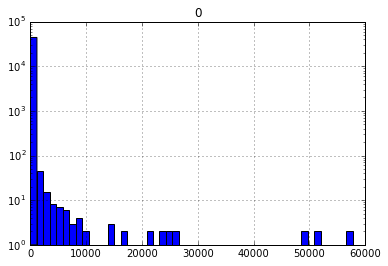

In [19]:
pd.DataFrame( [elem[1] for elem in wc_desc] ).hist(bins=50 , log=True, bottom=1)

出現回数が少ない単語が非常に多いことが分かります。<br>
ここで得られた分布が一般的なものかどうかをみるために、単語の出現頻度とその順位に関する Zipf's law ( https://en.wikipedia.org/wiki/Zipf%27s_law ) が成り立つかを調べてみます。<br>

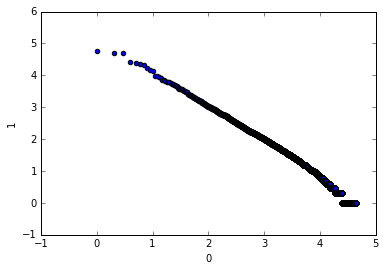

In [20]:
pd.DataFrame( 
    [( np.log10(idx), np.log10(word_count[1]) ) for idx, word_count in enumerate(wc_desc, start=1)]
).plot(x=0, y=1,kind='scatter')

綺麗にべき分布に乗っている様子が確認できます。<br>
さらに、具体的に対出現回数が多い上位の単語を眺めてみます。

In [21]:
wc_desc[0:20]

[(',', 57760),
 ('the', 50839),
 ('.', 49517),
 ('a', 25993),
 ('and', 24391),
 ('of', 23109),
 ('to', 21059),
 ('is', 16935),
 ('in', 14737),
 ('"', 14187),
 ('that', 9892),
 (')', 9230),
 ('(', 9182),
 ('it', 8144),
 ('with', 7389),
 ('as', 7368),
 ('for', 6791),
 ('his', 6405),
 ('this', 6384),
 ('film', 6085)]

上位に現れる単語は判別には到底関係なさそうな単語や文字列が並んでいるように見えます。<br>
これらの単語や文字列はモデルには必要ないと考えられるため、特定の単語や文字列を削除するスクリプトを作成して除外するようにします。<br>

re.escape : メタ文字をエスケープ　ex.) re.escape(r'*.txt') → /*/.txt <br>
map : 全ての要素に処理を行う　ex.) map(func, [a,b,c]) → [func(a), func(b), func(c)]  <br>
re.compile(string).sub(x, y) : string にある x を y に置換する <br>

pythonの正規表現に関しては https://github.com/tartley/python-regex-cheatsheet/blob/master/cheatsheet.rst などが参考になります。

In [22]:
def multiple_replace(dict, text):
    # Compile regular expressions
    regex = re.compile( r"(%s)" % "|".join( map(re.escape, dict.keys()) ) )

    # Replace
    return regex.sub( lambda x: dict[ x.string[x.start():x.end()] ], text ) 

関数の振る舞いが望ましいものかを確認します。

In [23]:
multiple_replace({'1': "", '2' : "200"}, "condition1 is condition2")

'condition is condition200'

この関数を使って置換の辞書を作成してみます。<br>
例えば出現回数は多いがそれ自体は意味を持たない記号や出現回数が少なくて有用でない単語などが考えられます。<br>
出現回数が少ないものとして、ここでは一度しか現れない単語を抜き出してみます。<br>

In [24]:
print(wc_desc[0:20])

for i in range(len(wc_asc)):
    if wc_asc[i][1] == 2:
        print("End position of counting number = 1 :", i)
        break

[(',', 57760), ('the', 50839), ('.', 49517), ('a', 25993), ('and', 24391), ('of', 23109), ('to', 21059), ('is', 16935), ('in', 14737), ('"', 14187), ('that', 9892), (')', 9230), ('(', 9182), ('it', 8144), ('with', 7389), ('as', 7368), ('for', 6791), ('his', 6405), ('this', 6384), ('film', 6085)]
End position of counting number = 1 : 19571


適切な場所が抜き出せているかを確認します。

In [25]:
wc_asc[19570:19580]

[('misjudged', 1),
 ('reggae', 2),
 ('exchanging', 2),
 ("creatures'", 2),
 ('castellano', 2),
 ('mugge', 2),
 ('twitches', 2),
 ('unspectacular', 2),
 ("therapist's", 2),
 ('cushing', 2)]

ここでは出現回数が多い単語のみを辞書に登録しておきます。（出現回数が少ないものを削ると精度が落ちてしまうため）<br>
以下のセルでは出現回数の多いものと少ないものの辞書を作る処理を準備しましたが、コメントアウトしています。<br>
代わりにその下のセルで明示的に辞書を作成しています。

In [26]:
#target_dicts = {"":""}

#for i in range(10):
#    target_dicts[ " "+wc_desc[i][0]+" " ] = ' '

#for i in range(19571):
#    target_dicts[ " "+wc_asc[i][0]+" " ] = ''

スペースの入れ方に気をつけて辞書を定義します。<br>
ここではごく一部だけを採用しすることにします。

In [27]:
target_dicts = {
    '"': ''
    , ',': ''
    , '.': ''
    , ' a ': ' '
    , ' and ': ' '
    , ' in ': ' '
    , ' is ': ' '
    , ' of ': ' '
    , ' the ': ' '
    , ' to ': ' '
    , '-': ' '
    , '(': ' '
    , ')': ' '
}

これまでの内容を取り入れた処理を実施する関数を定義します。かなり ad hoc な作り方になっていますが、何をしているのか読み解いて見てください。<br>
さらに論文に従って not で始まる単語に関してはその次の単語まで含めた単語を作ります。 ex.) not good → not_good <br>

In [28]:
def text_processor(text, target_dicts):
    text = re.sub( r'\*.\*.\*.\*.\*{0}+\*.\*.\*.\*{0}+\*.\*.\*{0}+\*.\*{0}+\*[^\.]+\.'.format('[^\*]'), " " , text )
    text = re.sub( r'<a(.*?)</a>',"html_tag", text )

    processed_text = multiple_replace(target_dicts, text)
    words = processed_text.lower().strip().split()
    
    not_bigram = [ "{0}_{1}".format(i,j) for i,j in zip(words, words[1:]) if i.lower() in ["not"] ]
    words.extend( not_bigram )

    count_dicts = collections.Counter(words)
    
    return count_dicts


def get_feature_count(file_paths, target_dicts):
    result = []
    python_version = sys.version_info.major
    
    if python_version >= 3:
        for idx, file in enumerate(file_paths, start=1):
            print( "{0}th data is being processed.".format(idx) ) if idx % 100 == 0 else None 
            with open(file, 'r', encoding='utf-8') as f:
                for line in f:
                    count_dicts = text_processor(line, target_dicts)
                    result.append( dict(count_dicts) )
        return result
    else:
        for idx, file in enumerate(file_paths, start=1):
            print( "{0}th data is being processed.".format(idx) ) if idx % 100 == 0 else None 
            with open(file, 'r') as f:
                for line in f:
                    count_dicts = text_processor(line, target_dicts)
                    result.append( dict(count_dicts) )
        return result

関数の振る舞いを確認します。

In [29]:
text_processor("I am a great data scientist. But my code is not good", target_dicts)

Counter({'am': 1,
         'but': 1,
         'code': 1,
         'data': 1,
         'good': 1,
         'great': 1,
         'i': 1,
         'my': 1,
         'not': 1,
         'not_good': 1,
         'scientist': 1})

処理を実行して unigram feature を作成します。

In [30]:
%%time

word_feature = \
    get_feature_count( neg_files[:DATA_NUM], target_dicts ) \
    + get_feature_count( pos_files[:DATA_NUM], target_dicts )

100th data is being processed.
200th data is being processed.
300th data is being processed.
400th data is being processed.
500th data is being processed.
600th data is being processed.
700th data is being processed.
100th data is being processed.
200th data is being processed.
300th data is being processed.
400th data is being processed.
500th data is being processed.
600th data is being processed.
700th data is being processed.
CPU times: user 1.18 s, sys: 146 ms, total: 1.33 s
Wall time: 1.71 s


In [31]:
print(word_feature[2])

{'brooding': 1, 'they': 1, 'from': 2, 'marsha': 2, '?': 1, 'them': 1, 'both': 1, 'watching': 1, 'be': 1, 'gary': 1, 'still': 2, 'street': 1, 'seventies': 1, 'niche': 1, 'with': 2, 'on': 2, 'a': 3, 'years': 1, 'see': 1, 'her': 3, 'christine': 1, 'while': 1, 'brady': 6, 'though': 1, 'you': 1, 'granted': 1, 'blues': 1, 'by': 2, 'sanitary': 1, 'seems': 1, 'has': 3, 'uniformly': 1, 'manor': 1, 'exception': 1, 'for': 1, 'this': 2, 'sitcom': 1, 'taylor': 1, 'what': 1, 'should': 1, 'reruns': 1, 'changed': 1, 'at': 1, 'not': 2, 'rod': 1, 'point': 1, 'plot': 1, 'between': 1, 'disturbing': 1, 'serling': 1, 'make': 1, 'really': 1, 'some': 1, 'sexual': 1, 'minor': 1, 'future': 1, 'problem': 1, "she's": 1, 'out': 2, 'brushing': 1, 'innuendo': 1, 'yet': 1, 'garish': 1, 'fame': 1, 'nite': 1, 'alice': 1, 'ago': 1, 'material': 1, 'right': 1, 'sharp': 1, 'delight': 1, "isn't": 1, "tv's": 1, 'expect': 1, 'chicks': 1, "it's": 2, 'considers': 1, 'everything': 1, 'betty': 1, 'day': 1, 'production': 1, 'world

## 3.モデルにインプットできる形へと変換

In [32]:
%%time
vec = DictVectorizer()
feature_vectors_csr = vec.fit_transform( word_feature )

CPU times: user 667 ms, sys: 25.2 ms, total: 692 ms
Wall time: 702 ms


In [33]:
feature_vectors_csr.data[ feature_vectors_csr.data > 0 ] = 1.

In [34]:
feature_vectors = feature_vectors_csr.toarray()
print( "input data dimension :", feature_vectors.shape )
print( feature_vectors[0] )
print( "data size :", sys.getsizeof(feature_vectors) / 1000000, "[MB]" )

input data dimension : (1400, 40321)
[ 0.  0.  0. ...,  0.  0.  0.]
data size : 451.595312 [MB]


ここで input data dimension が (1400, 40321) になっていることを確認してください。<br>

tf-idfを使って特徴量を作成します。
- sklearn.feature_extraction.text.TfidfVectorizer : 特徴ベクトルから tf-idf を作成<br>
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [36]:
%%time
transformer = TfidfTransformer()
feature_vectors = transformer.fit_transform( feature_vectors )

CPU times: user 1.6 s, sys: 251 ms, total: 1.85 s
Wall time: 2.18 s


In [37]:
labels = np.r_[np.tile(0, DATA_NUM), np.tile(1, DATA_NUM)]

乱数の seed を設定します。

In [38]:
np.random.seed(7789)
shuffle_order = np.random.choice( 2*DATA_NUM, 2*DATA_NUM, replace=False )

## 4.モデルの学習

In [39]:
def N_splitter(seq, N):
    avg = len(seq) / float(N)
    out = []
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
        
    return np.array(out)

In [40]:
def train_model(features, labels, method='SVM', parameters=None):
    ### set the model
    if method == 'SVM':
        model = svm.SVC()
    elif method == 'NB':
        model = naive_bayes.GaussianNB()
    elif method == 'RF':
        model = RandomForestClassifier()
    else:
        print("Set method as SVM (for Support vector machine), NB (for Naive Bayes) or RF (Random Forest)")
    ### set parameters if exists
    if parameters:
        model.set_params(**parameters)
    ### train the model
    model.fit( features, labels )
    ### return the trained model
    return model

def predict(model, features):
    predictions = model.predict( features )
    return predictions

def evaluate_model(predictions, labels):
    data_num = len(labels)
    correct_num = np.sum( predictions == labels )
    return data_num, correct_num

def cross_validate(n_folds, feature_vectors, labels, shuffle_order, method='SVM', parameters=None):
    result_test_num = []
    result_correct_num = []
    
    n_splits = N_splitter( range(2*DATA_NUM), n_folds )

    for i in range(n_folds):
        print( "Executing {0}th set...".format(i+1) )
        test_elems = shuffle_order[ n_splits[i] ]
        train_elems = np.array([])
        train_set = n_splits[ np.arange(n_folds) !=i ]
        for j in train_set:
            train_elems = np.r_[ train_elems, shuffle_order[j] ]
        train_elems = train_elems.astype(np.integer)

        # train
        model = train_model( feature_vectors[train_elems], labels[train_elems], method, parameters )
        # predict
        predictions = predict( model, feature_vectors[test_elems] )
        # evaluate
        test_num, correct_num = evaluate_model( predictions, labels[test_elems] )
        result_test_num.append( test_num )
        result_correct_num.append( correct_num )
    
    return result_test_num, result_correct_num

In [41]:
N_FOLDS = 3

パラメタをチューニングして精度を検証してみます。

In [42]:
%%time

search_parameters = [
    {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [0.1, 1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]}
]

model = svm.SVC()
clf = grid_search.GridSearchCV(model, search_parameters)
clf.fit( feature_vectors, labels )

CPU times: user 4min 46s, sys: 3.12 s, total: 4min 49s
Wall time: 4min 59s


In [43]:
%%time

ans, corr = cross_validate(N_FOLDS, feature_vectors, labels, shuffle_order, method='SVM', parameters=clf.best_params_)

Executing 1th set...
Executing 2th set...
Executing 3th set...
CPU times: user 14.4 s, sys: 171 ms, total: 14.6 s
Wall time: 15.2 s


In [44]:
print( "average precision : ", np.around( 100.*sum(corr)/sum(ans), decimals=1 ), "%" )

average precision :  85.1 %


論文の精度である 82.9% を上回ることができました！<br>
ここで実施しているのは特徴量作成のごく一部ですので、さらなる精度向上を目指して様々な創意工夫をしてみてください。<br>

## 5.その他

その他によく使われる特徴量としては、例えば隣り合う単語を一つの組として数える bigram があります。<br>
このNotebookでは使用していないですが、紹介だけしておきます。

In [45]:
# from itertools import tee

# def bigrams(iterable):
#     a, b = tee(iterable)
#     next(b, None)
#     return zip(a, b)

これ以上の処理を行うならば、自然言語処理の部分に踏み込んで分析を行う必要性が出てきます。<br>
有名なライブラリとしては NLTK( http://www.nltk.org/ )などがあります。<br>

このNotebookで使用した評判分析で使える英語のレビューデータセットは http://text-analytics101.rxnlp.com/2011/07/user-review-datasets_20.html にまとめられています。